In [34]:
import pandas as pd, glob, os
all_files = glob.glob("*_sell.csv")
for fp in all_files:
    df_head = pd.read_csv(fp, nrows=3)
    print(os.path.basename(fp), "->", list(df_head.columns))


dachang_sell.csv -> ['area_sqm', 'unit_price_yuan_per_sqm']
yizhuang_sell.csv -> ['area_sqm', 'rent_yuan_per_month']
majiaoqiao_sell.csv -> ['area_sqm', 'unit_price_yuan_per_sqm']
yanjiao_sell.csv -> ['area_sqm', 'unit_price_yuan_per_sqm']


Found 1251 duplicated listings (33.87% of total data).
✅ merged shape: (3694, 3)
🔍 duplicates found: 1251 (33.87%)
✅ after dedup shape: (2443, 3)
✅ after outlier removal shape: (2370, 4)
📊 Sell summary by block (after dedup & outlier removal):


,listing_count,median_area,median_price_per_m2,mean_price_per_m2
block,,,,
yizhuang,742,148.72,58305.0,58621.58
majiaoqiao,790,93.30,28369.5,28338.41
yanjiao,769,86.72,10192.0,10634.43
dachang,69,90.00,6514.0,6341.23


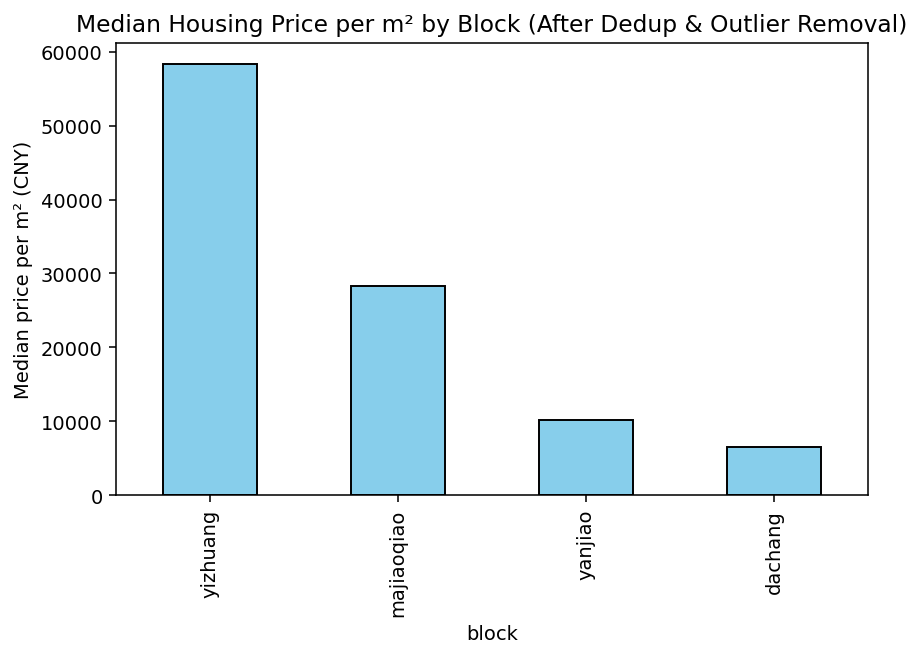

In [125]:
#check duplicates
dup_count = sell_df.duplicated(subset=["block", "area", "price_per_m2"]).sum()
total_count = len(sell_df)
dup_ratio = dup_count / total_count * 100

print(f"Found {dup_count} duplicated listings ({dup_ratio:.2f}% of total data).")
# Cuz one homelander may find 

# Remove duplicates because about 33.9% of listings are repeated by different agencies.
# Duplicates would overcount some houses and bias the average/median price.

# Merge -> Deduplicate -> Outliers -> Summary (sell data)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os

plt.rcParams["figure.dpi"] = 140

# ---------- 1) Merge all 4 sell CSVs ----------
frames = []
for fp in glob.glob("*_sell.csv"):
    df = pd.read_csv(fp)
    cols = list(df.columns)

    # unify headers: both variants map to "price_per_m2"
    price_col = "unit_price_yuan_per_sqm" if "unit_price_yuan_per_sqm" in cols else "rent_yuan_per_month"
    df = df.rename(columns={
        "area_sqm": "area",
        price_col: "price_per_m2"
    })

    # add block from filename
    block = os.path.basename(fp).replace("_sell.csv", "")
    df["block"] = block

    # numeric coercion and basic validity
    df["area"] = pd.to_numeric(df["area"], errors="coerce")
    df["price_per_m2"] = pd.to_numeric(df["price_per_m2"], errors="coerce")
    df = df[(df["area"] > 0) & (df["price_per_m2"] > 0)]

    frames.append(df)

sell_df = pd.concat(frames, ignore_index=True)
print(f"✅ merged shape: {sell_df.shape}")

# ---------- 2) Deduplicate BEFORE any stats ----------
# Remove duplicates because about 33.9% of listings are repeated by different agencies.
# Duplicates would overcount some houses and bias the average/median price.
dup_mask = sell_df.duplicated(subset=["block", "area", "price_per_m2"])
dup_count = int(dup_mask.sum())
dup_ratio = dup_count / len(sell_df) * 100 if len(sell_df) else 0
print(f"🔍 duplicates found: {dup_count} ({dup_ratio:.2f}%)")

sell_df_dedup = sell_df.drop_duplicates(subset=["block", "area", "price_per_m2"]).copy()
print(f"✅ after dedup shape: {sell_df_dedup.shape}")

# ---------- 3) Flag outliers per block (IQR) WITHOUT groupby.apply ----------
# compute per-block Q1, Q3, IQR using transform (safer and returns aligned vectors)
g = sell_df_dedup.groupby("block")["price_per_m2"]
q1 = g.transform(lambda s: s.quantile(0.25))
q3 = g.transform(lambda s: s.quantile(0.75))
iqr = q3 - q1
low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr

# boolean mask for outliers
sell_df_dedup["is_outlier"] = (sell_df_dedup["price_per_m2"] < low) | (sell_df_dedup["price_per_m2"] > high)
sell_df_dedup["is_outlier"] = sell_df_dedup["is_outlier"].astype(bool)

outlier_counts = (
    sell_df_dedup.groupby("block")["is_outlier"]
    .sum()
    .rename("outlier_count")
    .reset_index()
)

# cleaned data after dropping outliers
sell_df_clean = sell_df_dedup[~sell_df_dedup["is_outlier"]].copy()
print(f"✅ after outlier removal shape: {sell_df_clean.shape}")

# ---------- 4) Summary (per block, AFTER dedup and outlier removal) ----------

median_price_per_m2 = (
    sell_df_clean
    .groupby("block")["price_per_m2"]
    .median()
    .rename("median_price_per_m2")
)

mean_price_per_m2 = (
    sell_df_clean
    .groupby("block")["price_per_m2"]
    .mean()
    .rename("mean_price_per_m2")
)

median_area = (
    sell_df_clean
    .groupby("block")["area"]
    .median()
    .rename("median_area")
)

listing_count = (
    sell_df_clean
    .groupby("block")["price_per_m2"]
    .count()
    .rename("listing_count")
)

summary_df = pd.concat(
    [listing_count, median_area, median_price_per_m2, mean_price_per_m2],
    axis=1
).sort_values("median_price_per_m2", ascending=False).round(2)

print("📊 Sell summary by block (after dedup & outlier removal):")
display(summary_df) 


# ---------- 5) Plot median price per m² by block ----------
median_ppm2 = (
    sell_df_clean
    .groupby("block")["price_per_m2"]
    .median()
    .sort_values(ascending=False)
)

plt.figure()
median_ppm2.plot(
    kind="bar",
    color="skyblue",
    edgecolor="black"
)
plt.ylabel("Median price per m² (CNY)")
plt.title("Median Housing Price per m² by Block (After Dedup & Outlier Removal)")
plt.tight_layout()
plt.show()


✅ merged rent shape: (5063, 4)
🔍 rent duplicates found: 2510 (49.58%)
✅ after rent dedup shape: (2553, 4)
✅ after rent outlier removal shape: (2396, 5)
📊 Rent summary by block (after dedup & outlier removal):


,block,median_area,median_rent_per_m2,mean_rent_per_m2,median_rent_monthly,mean_rent_monthly,outlier_count
4,yizhuang,134.0,74.14,76.50,9500.0,11678.52,22
2,majiaoqiao_rent_all_pages_area,89.0,50.00,51.57,4200.0,4933.89,31
1,majiaoqiao,90.0,49.28,49.92,4500.0,5009.86,39
3,yanjiao,87.0,21.79,22.12,1750.0,1978.84,38
0,dachang,91.0,14.48,14.63,1225.0,1472.98,27


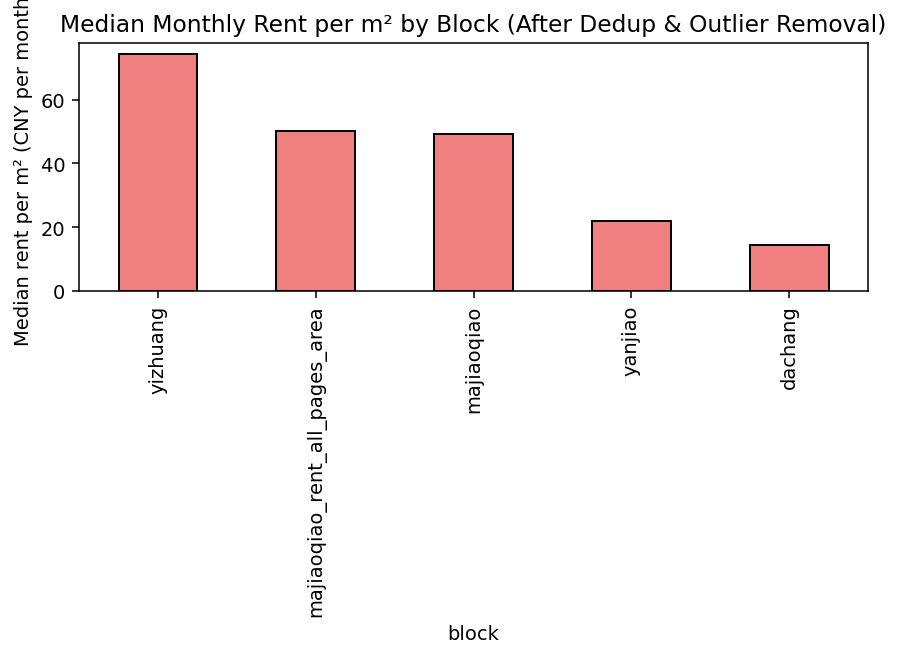

📊 Median price-to-rent ratio by block:


,median_price_per_m2,median_rent_per_m2,price_to_rent_ratio
block,,,
dachang,6514.0,14.48,449.76
majiaoqiao,28369.5,49.28,575.68
yanjiao,10192.0,21.79,467.63
yizhuang,58305.0,74.14,786.44
majiaoqiao_rent_all_pages_area,NaN,50.00,NaN


In [123]:
# Rent data pipeline: Merge -> Deduplicate -> Outliers -> Summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os

plt.rcParams["figure.dpi"] = 140

# ---------- 1) Merge all 4 RENT CSVs ----------
frames_r = []
for fp in glob.glob("*_rent.csv"):
    df = pd.read_csv(fp)

    # unify headers
    df = df.rename(columns={
        "area_sqm": "area",
        "rent_yuan_per_month": "rent_monthly"
    })

    # add block from filename
    block = os.path.basename(fp).replace("_rent.csv", "")
    df["block"] = block

    # numeric coercion and basic validity
    df["area"] = pd.to_numeric(df["area"], errors="coerce")
    df["rent_monthly"] = pd.to_numeric(df["rent_monthly"], errors="coerce")
    df = df[(df["area"] > 0) & (df["rent_monthly"] > 0)]

    # compute monthly rent per m²
    df["rent_per_m2"] = df["rent_monthly"] / df["area"]

    frames_r.append(df)

rent_df = pd.concat(frames_r, ignore_index=True)
print(f"✅ merged rent shape: {rent_df.shape}")
rent_df.head()


# ---------- 2) Deduplicate BEFORE any stats ----------
# Remove duplicates because repeated listings by multiple agencies bias averages/medians.
dup_mask_r = rent_df.duplicated(subset=["block", "area", "rent_per_m2"])
dup_count_r = int(dup_mask_r.sum())
dup_ratio_r = dup_count_r / len(rent_df) * 100 if len(rent_df) else 0
print(f"🔍 rent duplicates found: {dup_count_r} ({dup_ratio_r:.2f}%)")

rent_df_dedup = rent_df.drop_duplicates(subset=["block", "area", "rent_per_m2"]).copy()
print(f"✅ after rent dedup shape: {rent_df_dedup.shape}")

# ---------- 3) Flag outliers per block (IQR) on rent_per_m2 ----------
# Use transform to avoid groupby.apply pitfalls and keep aligned vectors
g_r = rent_df_dedup.groupby("block")["rent_per_m2"]
q1_r = g_r.transform(lambda s: s.quantile(0.25))
q3_r = g_r.transform(lambda s: s.quantile(0.75))
iqr_r = q3_r - q1_r
low_r = q1_r - 1.5 * iqr_r
high_r = q3_r + 1.5 * iqr_r

rent_df_dedup["is_outlier"] = (rent_df_dedup["rent_per_m2"] < low_r) | (rent_df_dedup["rent_per_m2"] > high_r)
rent_df_dedup["is_outlier"] = rent_df_dedup["is_outlier"].astype(bool)

outlier_counts_r = (
    rent_df_dedup.groupby("block")["is_outlier"]
    .sum()
    .rename("outlier_count")
    .reset_index()
)

rent_df_clean = rent_df_dedup[~rent_df_dedup["is_outlier"]].copy()
print(f"✅ after rent outlier removal shape: {rent_df_clean.shape}")


# ---------- 4) Summary (per block, AFTER dedup and outlier removal) ----------

median_rent_per_m2 = (
    rent_df_clean
    .groupby("block")["rent_per_m2"]
    .median()
    .rename("median_rent_per_m2")
)

mean_rent_per_m2 = (
    rent_df_clean
    .groupby("block")["rent_per_m2"]
    .mean()
    .rename("mean_rent_per_m2")
)

median_rent_monthly = (
    rent_df_clean
    .groupby("block")["rent_monthly"]
    .median()
    .rename("median_rent_monthly")
)

mean_rent_monthly = (
    rent_df_clean
    .groupby("block")["rent_monthly"]
    .mean()
    .rename("mean_rent_monthly")
)

median_area = (
    rent_df_clean
    .groupby("block")["area"]
    .median()
    .rename("median_area")
)

rent_summary = pd.concat(
    [median_area, median_rent_per_m2, mean_rent_per_m2,
     median_rent_monthly, mean_rent_monthly],
    axis=1
)

rent_summary = rent_summary.merge(outlier_counts_r, on="block", how="left")

rent_summary = rent_summary.sort_values("median_rent_per_m2", ascending=False).round(2)

print("📊 Rent summary by block (after dedup & outlier removal):")
display(rent_summary)



# ---------- 5) Plot median rent per m² by block ----------
median_rent = (
    rent_df_clean
    .groupby("block")["rent_per_m2"]
    .median()
    .sort_values(ascending=False)
)

plt.figure()
median_rent.plot(kind="bar", color="lightcoral", edgecolor="black")
plt.ylabel("Median rent per m² (CNY per month)")
plt.title("Median Monthly Rent per m² by Block (After Dedup & Outlier Removal)")
plt.tight_layout()
plt.show()


# ---------- Calculate median price-to-rent ratio for each block ----------

# 1️⃣ median price per m² (from cleaned sell data)
median_price = (
    sell_df_clean
    .groupby("block")["price_per_m2"]
    .median()
    .rename("median_price_per_m2")
)

# 2️⃣ median rent per m² (from cleaned rent data)
median_rent = (
    rent_df_clean
    .groupby("block")["rent_per_m2"]
    .median()
    .rename("median_rent_per_m2")
)

# 3️⃣ merge both
ratio_df = pd.concat([median_price, median_rent], axis=1)
ratio_df["price_to_rent_ratio"] = ratio_df["median_price_per_m2"] / ratio_df["median_rent_per_m2"]

print("📊 Median price-to-rent ratio by block:")
ratio_df.round(2)


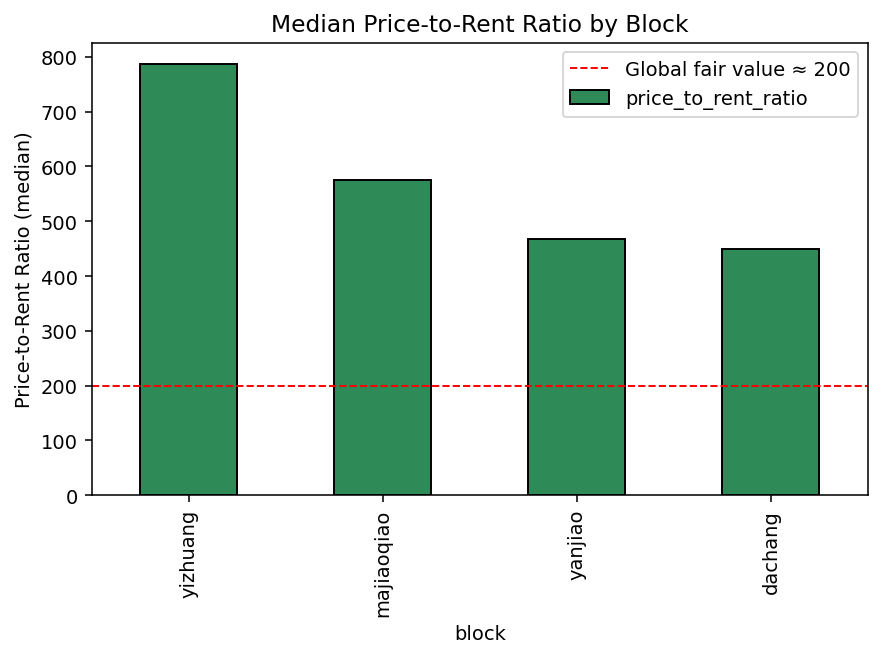

In [60]:
plt.figure()
ratio_df["price_to_rent_ratio"].sort_values(ascending=False).plot(
    kind="bar",
    color="seagreen",
    edgecolor="black"
)
plt.axhline(200, color="red", linestyle="--", linewidth=1, label="Global fair value ≈ 200")
plt.ylabel("Price-to-Rent Ratio (median)")
plt.title("Median Price-to-Rent Ratio by Block")
plt.legend()
plt.tight_layout()
plt.show()

In [127]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# merge both sell & rent data by block (not one-to-one, just for modeling)
sell_data = sell_df_clean.copy()
rent_data = rent_df_clean.copy()

# make sure consistent variable naming
sell_data = sell_data[["area", "block", "price_per_m2"]]
rent_data = rent_data[["area", "block", "rent_per_m2"]]

# encode block as categorical variable (one-hot encoding)
sell_X = pd.get_dummies(sell_data[["area", "block"]], drop_first=True)
rent_X = pd.get_dummies(rent_data[["area", "block"]], drop_first=True)

print("✅ Data ready for regression")

✅ Data ready for regression


In [64]:
# Model 1: predict price_per_m2
lm_price = LinearRegression()
lm_price.fit(sell_X, sell_data["price_per_m2"])

sell_data["pred_price_per_m2"] = lm_price.predict(sell_X)
print("✅ Model 1 (price) done.")

✅ Model 1 (price) done.


In [68]:
# Model 2: predict rent_per_m2
lm_rent = LinearRegression()
lm_rent.fit(rent_X, rent_data["rent_per_m2"])

rent_data["pred_rent_per_m2"] = lm_rent.predict(rent_X)
print("✅ Model 2 (rent) done.")


✅ Model 2 (rent) done.


In [70]:
# Calculate median predicted price-to-rent ratio for each block
pred_ratio = (
    pd.concat([
        sell_data[["block", "pred_price_per_m2"]],
        rent_data[["block", "pred_rent_per_m2"]]
    ])
    .groupby("block")
    .agg({"pred_price_per_m2": "median", "pred_rent_per_m2": "median"})
)

pred_ratio["pred_price_to_rent_ratio"] = pred_ratio["pred_price_per_m2"] / pred_ratio["pred_rent_per_m2"]

print("📊 Predicted median price-to-rent ratio by block:")
pred_ratio.round(2)

📊 Predicted median price-to-rent ratio by block:


,pred_price_per_m2,pred_rent_per_m2,pred_price_to_rent_ratio
block,,,
dachang,6267.80,14.63,428.45
majiaoqiao,28104.43,49.91,563.08
yanjiao,10637.04,22.12,480.96
yizhuang,58385.09,76.49,763.28


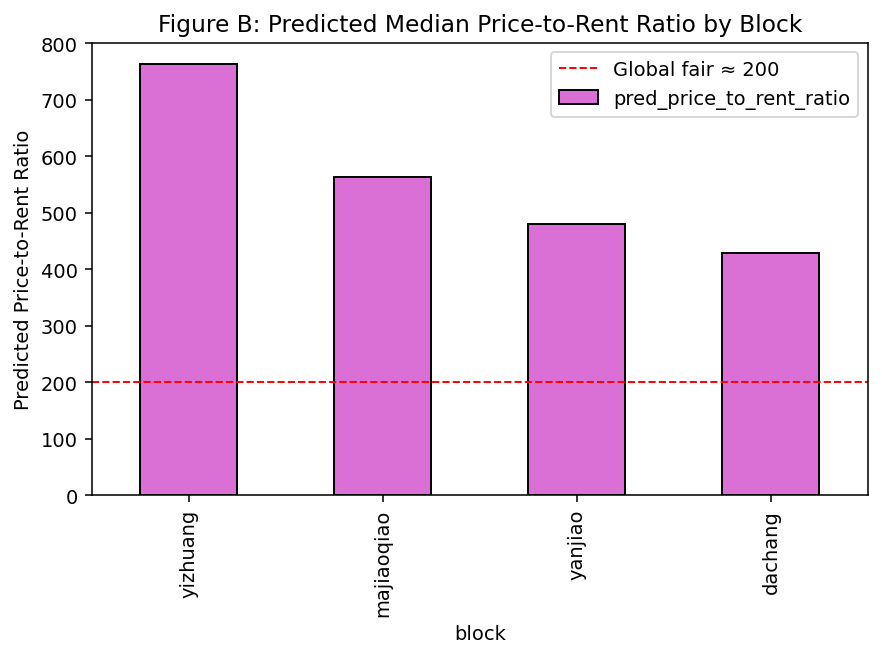

In [72]:
import matplotlib.pyplot as plt

plt.figure()
pred_ratio["pred_price_to_rent_ratio"].sort_values(ascending=False).plot(
    kind="bar",
    color="orchid",
    edgecolor="black"
)
plt.axhline(200, color="red", linestyle="--", linewidth=1, label="Global fair ≈ 200")
plt.ylabel("Predicted Price-to-Rent Ratio")
plt.title("Figure B: Predicted Median Price-to-Rent Ratio by Block")
plt.legend()
plt.tight_layout()
plt.show()


In [74]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

# features: area + location dummies
sell_X = pd.get_dummies(sell_df_clean[["area", "block"]], drop_first=True)
rent_X = pd.get_dummies(rent_df_clean[["area", "block"]], drop_first=True)
y_price = sell_df_clean["price_per_m2"]
y_rent  = rent_df_clean["rent_per_m2"]


In [76]:
lm_price = LinearRegression().fit(sell_X, y_price)
lm_rent  = LinearRegression().fit(rent_X, y_rent)
r2_price = r2_score(y_price, lm_price.predict(sell_X))
r2_rent  = r2_score(y_rent,  lm_rent.predict(rent_X))
print(f"Model 1 R² (price): {r2_price:.4f}")
print(f"Model 2 R² (rent):  {r2_rent:.4f}")

Model 1 R² (price): 0.8188
Model 2 R² (rent):  0.8296


In [78]:
# polynomial + interaction terms
poly = PolynomialFeatures(degree=2, include_bias=False)
sell_X_plus = pd.get_dummies(sell_df_clean[["block"]], drop_first=True)
rent_X_plus = pd.get_dummies(rent_df_clean[["block"]], drop_first=True)

# add nonlinear features of area
sell_poly = poly.fit_transform(sell_df_clean[["area"]])
rent_poly = poly.fit_transform(rent_df_clean[["area"]])

# merge nonlinear & location
sell_X_plus = np.concatenate([sell_poly, sell_X_plus.values], axis=1)
rent_X_plus = np.concatenate([rent_poly, rent_X_plus.values], axis=1)

lm_price_plus = LinearRegression().fit(sell_X_plus, y_price)
lm_rent_plus  = LinearRegression().fit(rent_X_plus, y_rent)
r2_price_plus = r2_score(y_price, lm_price_plus.predict(sell_X_plus))
r2_rent_plus  = r2_score(y_rent,  lm_rent_plus.predict(rent_X_plus))
print(f"Model 1⁺ R² (price): {r2_price_plus:.4f}")
print(f"Model 2⁺ R² (rent):  {r2_rent_plus:.4f}")


Model 1⁺ R² (price): 0.8245
Model 2⁺ R² (rent):  0.8357


In [80]:
# predicted values
pred_price_plus = lm_price_plus.predict(sell_X_plus)
pred_rent_plus  = lm_rent_plus.predict(rent_X_plus)

sell_df_clean["pred_price_plus"] = pred_price_plus
rent_df_clean["pred_rent_plus"]  = pred_rent_plus

# median ratio by block
ratio_plus = (
    pd.concat([
        sell_df_clean.groupby("block")["pred_price_plus"].median(),
        rent_df_clean.groupby("block")["pred_rent_plus"].median()
    ], axis=1)
)
ratio_plus["pred_ratio_plus"] = ratio_plus["pred_price_plus"] / ratio_plus["pred_rent_plus"]
ratio_plus.round(2)

,pred_price_plus,pred_rent_plus,pred_ratio_plus
block,,,
dachang,6141.60,14.68,418.35
majiaoqiao,27897.76,49.82,559.94
yanjiao,10777.56,21.85,493.18
yizhuang,59160.55,75.80,780.47


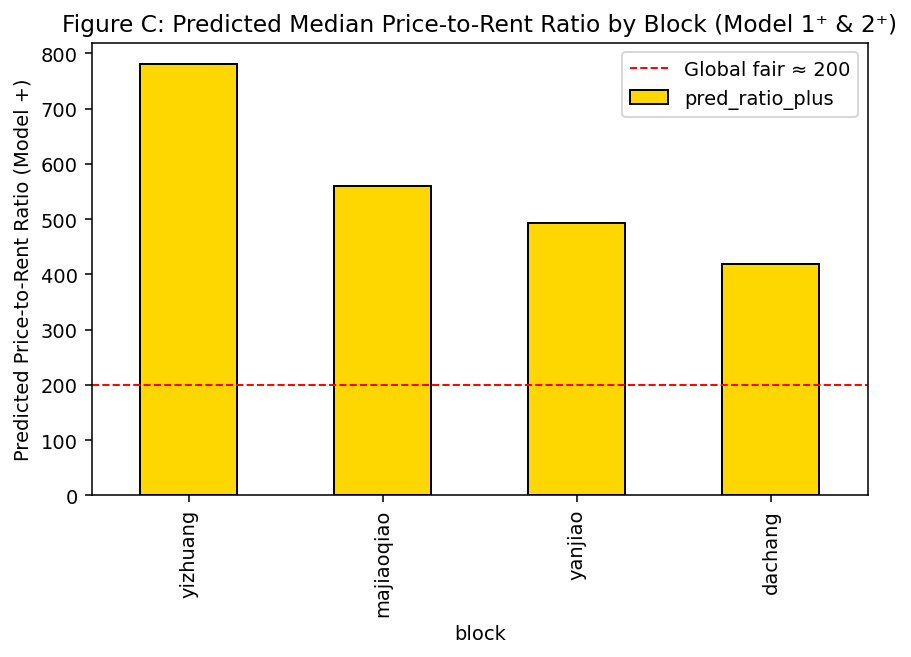

In [82]:
import matplotlib.pyplot as plt

plt.figure()
ratio_plus["pred_ratio_plus"].sort_values(ascending=False).plot(
    kind="bar", color="gold", edgecolor="black"
)
plt.axhline(200, color="red", linestyle="--", linewidth=1, label="Global fair ≈ 200")
plt.ylabel("Predicted Price-to-Rent Ratio (Model +)")
plt.title("Figure C: Predicted Median Price-to-Rent Ratio by Block (Model 1⁺ & 2⁺)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Model 1⁺ and Model 2⁺ generally yield higher R² than linear models,
# because non-linear and interaction terms capture curvature (area²) and
# block-specific effects. Thus Model 1⁺ / 2⁺ fit the data better.